#### Imports & paths

In [ ]:
# Imports
import numpy as np
import duckdb
import pandas as pd
from pathlib import Path
import sys
import os
import matplotlib.pyplot as plt

if "__file__" in globals():
    ROOT = Path(__file__).resolve().parent.parent
else:
    ROOT = Path(os.getcwd()).parent

RAW = ROOT / "data" / "raw"
DB_PATH = ROOT / "data" / "ieee_fraud.duckdb"

conn = duckdb.connect(str(DB_PATH))

#### Quick sanity: row counts & join coverage

In [14]:
counts = conn.execute("""
                      SELECT 'train_transaction' AS table, COUNT(*) AS n FROM train_transaction
                      UNION ALL
                      SELECT 'train_identity' AS table, COUNT(*) FROM train_identity
                      UNION ALL
                      SELECT 'test_transaction' AS table, COUNT(*) AS n FROM test_transaction
                      UNION ALL
                      SELECT 'test_identity' AS table, COUNT(*) FROM test_identity
                      """).df()

coverage = conn.execute("""
                        SELECT
                            COUNT(*) AS with_identity,
                            (SELECT COUNT(*) FROM train_transaction) AS total
                        FROM train_transaction t
                        LEFT JOIN train_identity i USING (transactionID)
                        WHERE i.TransactionID IS NOT NULL
                        """).df()

counts, coverage

(               table       n
 0  train_transaction  590540
 1     train_identity  144233
 2   test_transaction  506691
 3      test_identity  141907,
    with_identity   total
 0         144233  590540)

#### Fraud rate & class imbalance

In [21]:
fraud_stats = conn.execute(""" 
                           SELECT 
                                COUNT(*) AS n_rows,
                                SUM(isFraud) AS n_fraud,
                                AVG(isFraud) AS fraud_rate
                            FROM train_transaction
                           """).df()
fraud_stats

,n_rows,n_fraud,fraud_rate
0,590540,20663.0,0.03499


#### Basic distributions (amount & time)

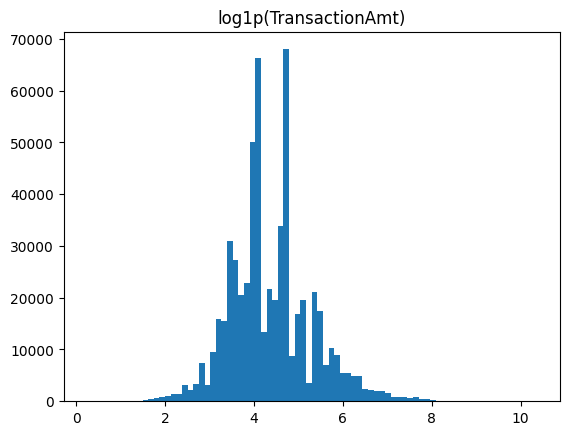

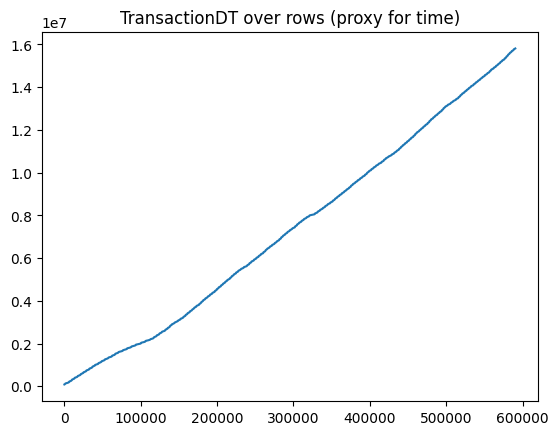

In [26]:
amt = conn.execute("""
                   SELECT TransactionAmt FROM train_transaction
                   WHERE TransactionAmt IS NOT NULL
                   """).df()

dt = conn.execute("""
                  SELECT TransactionDT from train_transaction
                  WHERE TransactionDT IS NOT NULL
                  ORDER BY TransactionDT
                  """).df()

fig, ax = plt.subplots()
ax.hist(np.log1p(amt["TransactionAmt"]), bins=80)
ax.set_title("log1p(TransactionAmt)")
plt.show()

fig, ax = plt.subplots()
ax.plot(dt["TransactionDT"].values)
ax.set_title("TransactionDT over rows (proxy for time)")
plt.show()



### Missingness profile (top 30)

In [28]:
df = conn.execute("""
                  SELECT * FROM train_joined
                  """).df()
null_pct = df.isna().mean().sort_values(ascending=False)
null_pct.head(30).to_frame("missing_rate")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,missing_rate
id_24,0.991962
id_25,0.991310
id_07,0.991271
id_08,0.991271
id_21,0.991264
id_26,0.991257
id_27,0.991247
id_23,0.991247
id_22,0.991247
dist2,0.936284


### Derive minimal time frequency (hour, day, weekday)

In [29]:
# TransactionDT is second from a reference. We can convert it to a pseudo datetime by picking an epoch.
# We only need relative features (hour/day/weekday), so exact origin doesn't matter.
dt0 = pd.Timestamp("2017-01-01") # arbitrary anchor
df["dt"] = dt0 + pd.to_timedelta(df["TransactionDT"].fillna(0), unit="s")
df["hour"] = df["dt"].dt.hour
df["day"] = (df["dt"].dt.normalize() - dt0.normalize()).dt.days
df["weekday"] = df["dt"].dt.weekday

df[["hour","day","weekday"]].describe()

,hour,day,weekday
count,590540.000000,590540.000000,590540.000000
mean,13.861923,84.729199,2.981815
std,7.607152,53.437277,2.049080
min,0.000000,1.000000,0.000000
25%,6.000000,35.000000,1.000000
50%,16.000000,84.000000,3.000000
75%,20.000000,130.000000,5.000000
max,23.000000,182.000000,6.000000


#### Quick fraud patterns by hour/weekday

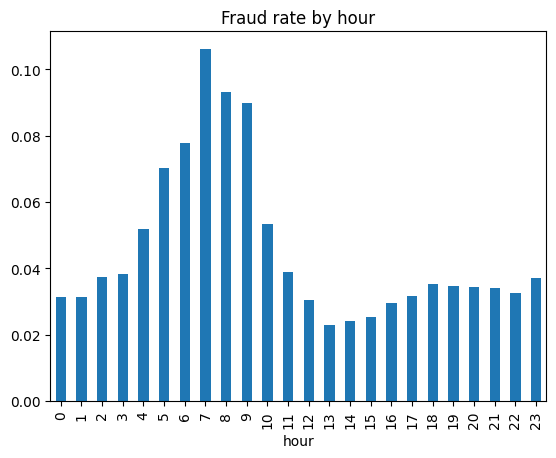

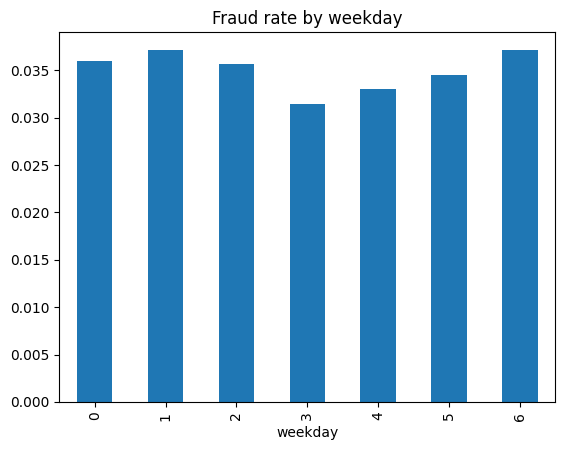

: 

In [ ]:
by_hour = df.groupby("hour")["isFraud"].mean()
by_weekday = df.groupby("weekday")["isFraud"].mean()

fig, ax = plt.subplots()
by_hour.plot(kind="bar", ax=ax)
ax.set_title("Fraud rate by hour")
plt.show()

fig, ax = plt.subplots()
by_weekday.plot(kind="bar", ax=ax)
ax.set_title("Fraud rate by weekday")
plt.show()